In [41]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [42]:
df=pd.read_csv('training.csv')

#make all strings
df['article_words']=df['article_words'].apply(str)

#get rid of commas/punctuation
punctuation_signs = list("?:!.,;")
df['article_words_parse_1'] = df['article_words']

for punct_sign in punctuation_signs:
    df['article_words_parse_1'] = df['article_words_parse_1'].str.replace(punct_sign, ' ')
    
#all lower case
df['article_words_parse_2'] = df['article_words_parse_1'].str.lower()

#NO STEMMING NO LEMMISATION, NO STOP WORDS

#Category Numbers
category_codes = {
    'ARTS CULTURE ENTERTAINMENT': 0,
    'BIOGRAPHIES PERSONALITIES PEOPLE': 1,
    'DEFENCE': 2,
    'DOMESTIC MARKETS': 3,
    'FOREX MARKETS': 4,
    'HEALTH': 5,
    'IRRELEVANT': 6,
    'MONEY MARKETS': 7,
    'SCIENCE AND TECHNOLOGY': 8,
    'SHARE LISTINGS': 9,
    'SPORTS': 10
}

# Category mapping
df['Category_Code'] = df['topic']
df = df.replace({'Category_Code':category_codes})


df = df.drop(["article_words", "article_words_parse_1"], axis=1)


print(df)

      article_number          topic  \
0                  1  FOREX MARKETS   
1                  2  MONEY MARKETS   
2                  3         SPORTS   
3                  4  FOREX MARKETS   
4                  5     IRRELEVANT   
...              ...            ...   
9495            9496        DEFENCE   
9496            9497     IRRELEVANT   
9497            9498  FOREX MARKETS   
9498            9499     IRRELEVANT   
9499            9500  FOREX MARKETS   

                                  article_words_parse_2  Category_Code  
0     open absent cent cent cent stock inflow rate k...              4  
1     morn stead end end day day day patch patch pat...              7  
2     socc socc world world recent law fifa fifa fif...             10  
3     open forint forint forint forint cent cent ste...              4  
4     morn complet weekend minut minut minut arrow d...              6  
...                                                 ...            ...  
9495  cloud provid h

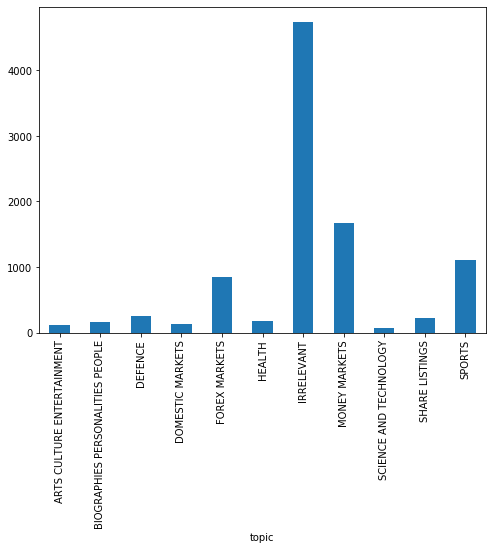

In [43]:
#Data Analysis
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('topic').article_words_parse_2.count().plot.bar(ylim=0)
plt.show()

In [47]:
#Try to get rid of Irrelevant

# 0=Irrelevant, 1=Relevant
new_code = {
    'ARTS CULTURE ENTERTAINMENT': 1,
    'BIOGRAPHIES PERSONALITIES PEOPLE': 1,
    'DEFENCE': 1,
    'DOMESTIC MARKETS': 1,
    'FOREX MARKETS': 1,
    'HEALTH': 1,
    'IRRELEVANT': 0,
    'MONEY MARKETS': 1,
    'SCIENCE AND TECHNOLOGY': 1,
    'SHARE LISTINGS': 1,
    'SPORTS': 1
}

new_name = {
    'ARTS CULTURE ENTERTAINMENT': 'RELEVANT',
    'BIOGRAPHIES PERSONALITIES PEOPLE': 'RELEVANT',
    'DEFENCE': 'RELEVANT',
    'DOMESTIC MARKETS': 'RELEVANT',
    'FOREX MARKETS': 'RELEVANT',
    'HEALTH': 'RELEVANT',
    'IRRELEVANT': 'IRRELEVANT1',
    'MONEY MARKETS': 'RELEVANT',
    'SCIENCE AND TECHNOLOGY': 'RELEVANT',
    'SHARE LISTINGS': 'RELEVANT',
    'SPORTS': 'RELEVANT'
}

# Category mapping
df['binary_code'] = df['topic']
df['binary_topic']=df['topic']
df = df.replace({'binary_code':new_code})
df = df.replace({'binary_topic':new_name})

X_train, X_test, y_train, y_test, topic_train, topic_test, category_train, category_test, article_train, article_test= train_test_split(df['article_words_parse_2'], 
                                                    df['binary_code'],df['topic'], df['Category_Code'], df['article_number'],
                                                    random_state=8)



In [48]:
#TFIDF
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 6000

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(7125, 6000)
(2375, 6000)


In [49]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [50]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['ovr']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['ovr'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [ ]:
# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [20]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)


The best hyperparameters from Random Search are:
{'solver': 'sag', 'penalty': 'l2', 'multi_class': 'ovr', 'class_weight': 'balanced', 'C': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.856140350877193


In [21]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['ovr']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.3min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=8, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_st...
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0],
            

In [22]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 1.0, 'class_weight': 'balanced', 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.8621031746031746


In [23]:
best_lrc = grid_search.best_estimator_
best_lrc

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=8, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:

best_lrc.fit(features_train, labels_train)

lrc_pred = best_lrc.predict(features_test)
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))


# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))



C:\Users\Stephen Sung\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


KeyboardInterrupt: 

In [37]:
aux_df = df[['binary_topic', 'binary_code']].drop_duplicates().sort_values('binary_code')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(6,3))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['binary_code'].values, 
            yticklabels=aux_df['binary_code'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [1154, 2375]

In [29]:
#https://towardsdatascience.com/naive-bayes-document-classification-in-python-e33ff50f937e
testing_predictions = []
for i in range(len(X_test)):
    if lrc_pred[i] == 1:
        testing_predictions.append('RELEVANT')
    else:
        testing_predictions.append('IRRELEVANT')
check_df = pd.DataFrame({'actual_label': list(y_test), 'prediction': testing_predictions, 'words':list(X_test), 'topic':list(topic_test), 'category':list(category_test), 'article':list(article_test)})
check_df.actual_label.replace(to_replace=0, value='IRRELEVANT', inplace=True)
check_df.actual_label.replace(to_replace=1, value='RELEVANT', inplace=True)

print(check_df)

check_df.category.unique()

     actual_label  prediction  \
0      IRRELEVANT  IRRELEVANT   
1        RELEVANT    RELEVANT   
2        RELEVANT  IRRELEVANT   
3        RELEVANT    RELEVANT   
4      IRRELEVANT  IRRELEVANT   
...           ...         ...   
2370   IRRELEVANT  IRRELEVANT   
2371     RELEVANT    RELEVANT   
2372     RELEVANT    RELEVANT   
2373   IRRELEVANT  IRRELEVANT   
2374   IRRELEVANT  IRRELEVANT   

                                                  words  \
0     fitch fitch artem correct correct group munici...   
1     flow vanhoos research research supercold nasa ...   
2     flow flow flow purchas purchas purchas purchas...   
3     hear investig investig cover cover seek hope c...   
4     regist cent ensur half half half half half sto...   
...                                                 ...   
2370  stead stead stead missor gilt top top moderat ...   
2371  option cent derivat daily daily cross local ba...   
2372  jerry issu heard jasinowsk jasinowsk assoc quo...   
2373  figur r

array([ 6,  8,  7,  2,  4,  9, 10,  1,  3,  5,  0], dtype=int64)

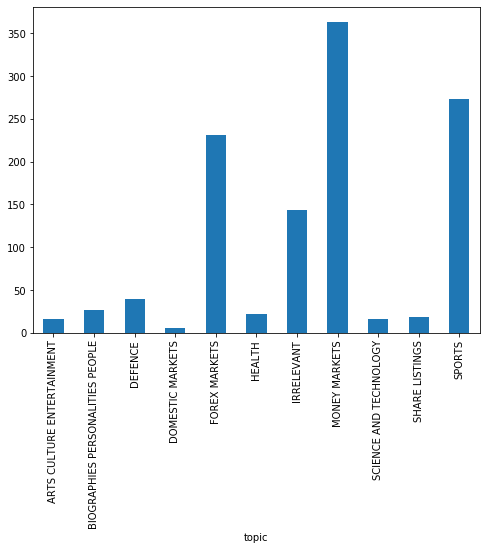

0        4
1        7
2       10
3        4
5        9
        ..
9491     1
9492     7
9495     2
9497     4
9499     4
Name: Category_Code, Length: 4766, dtype: int64
1       8
3       2
9       4
10      6
15      7
       ..
2363    4
2366    7
2367    6
2371    7
2372    4
Name: category, Length: 1154, dtype: int64
(4766, 6000)
(1154, 6000)


In [30]:
#THIS IS NOW OUR NEW TEST SET WITH NO IRRELEVANT FILES
check_df = check_df[check_df.prediction != 'IRRELEVANT']

#Data Analysis
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
check_df.groupby('topic').words.count().plot.bar(ylim=0)
plt.show()

#print(check_df) #

#get the original dataset and remove all irrelevant articles
new_df=df
new_df = new_df[new_df.topic != 'IRRELEVANT']
#print(new_df) #

X_train=new_df['article_words_parse_2']
X_test=check_df['words']
y_train=new_df['Category_Code']
y_test=check_df['category']

print(y_train)
print(y_test)

features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)


In [35]:
lr_1 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_1.get_params())

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [ ]:
# C
C1 = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class1 = ['multinomial']

# solver
solver1 = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight1 = ['balanced', None]

# penalty
penalty1 = ['l2']

# Create the random grid
random_grid1 = {'C': C1,
               'multi_class': multi_class1,
               'solver': solver1,
               'class_weight': class_weight1,
               'penalty': penalty1}

pprint(random_grid)

In [ ]:
# First create the base model to tune
lrc1 = LogisticRegression(random_state=8)

# Definition of the random search
random_search1 = RandomizedSearchCV(estimator=lrc1,
                                   param_distributions=random_grid1,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search1.fit(features_train, labels_train)

In [ ]:
print("The best hyperparameters from Random Search are:")
print(random_search1.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search1.best_score_)

In [ ]:
# Create the parameter grid based on the results of random search 
C1 = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class1 = ['multinomial']
solver1 = ['lbfgs']
class_weight1 = [None]
penalty1 = ['l2']

param_grid1 = {'C': C1,
               'multi_class': multi_class1,
               'solver': solver1,
               'class_weight': class_weight1,
               'penalty': penalty1}

# Create a base model
lrc1 = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets1 = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search1 = GridSearchCV(estimator=lrc1, 
                           param_grid=param_grid1,
                           scoring='accuracy',
                           cv=cv_sets1,
                           verbose=1)

# Fit the grid search to the data
grid_search1.fit(features_train, labels_train)

In [ ]:
print("The best hyperparameters from Grid Search are:")
print(grid_search1.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search1.best_score_)

In [ ]:
best_lrc1 = grid_search1.best_estimator_
best_lrc1


best_lrc1.fit(features_train, labels_train)

lrc_pred1 = best_lrc1.predict(features_test)
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc1.predict(features_train)))


# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred1))

In [ ]:
# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred1))

In [ ]:
aux_df = df[['topic', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, lrc_pred1)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['topic'].values, 
            yticklabels=aux_df['topic'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()